In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from os import path
import xarray as xr
import numpy as np
from gdc.utils import GDC_DATA_PATH
import statsmodels.formula.api as smf

In [2]:
df_labels = pd.read_feather(
    path.join(GDC_DATA_PATH, 'simulated', 'labels_export.feather')
)

df_labels.value_counts(normalize=True)

Power  ToU
9      1      0.2538
6      1      0.1995
9      0      0.1456
12     1      0.1418
6      0      0.0938
12     0      0.0669
6      2      0.0376
9      2      0.0343
12     2      0.0267
Name: proportion, dtype: float64

In [3]:
df_temp_simulated = pd.read_feather(
        path.join(GDC_DATA_PATH, 'simulated', 'temperature_export.feather')
)

In [4]:
df_temp_simulated.shape

(10000, 17424)

<Axes: >

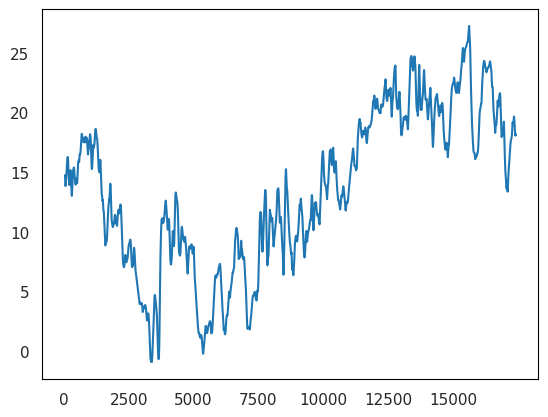

In [5]:
df_temp_simulated.mean(axis=0).rolling(48).mean().plot()

<Axes: >

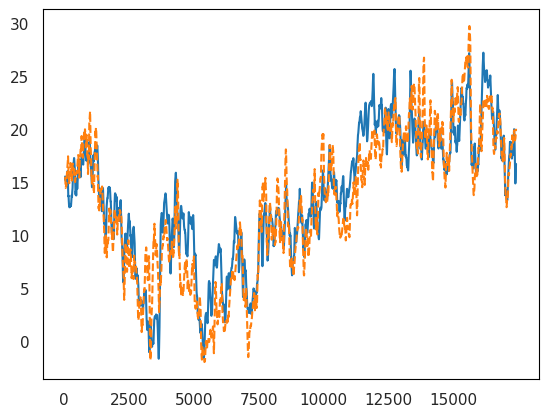

In [8]:
df_temp_simulated.iloc[0].rolling(48).mean().plot()
df_temp_simulated.iloc[1000].rolling(48).mean().plot()


<Axes: >

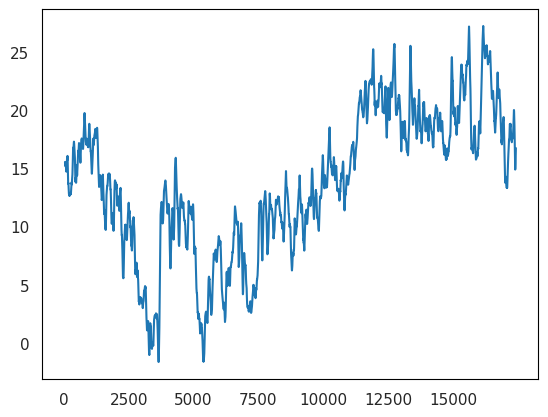

In [9]:
df_temp_simulated.iloc[0].rolling(48).mean().plot()

In [10]:
df_load = pd.read_feather(
    path.join(GDC_DATA_PATH, 'simulated', 'load_curve_export.feather')
)
df_load.shape

(10000, 17424)

<Axes: >

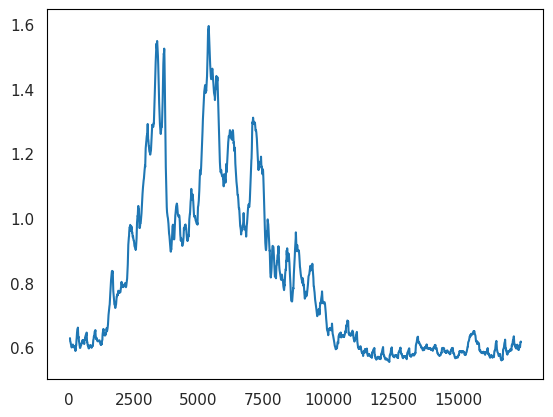

In [11]:
df_load.mean(axis=0).rolling(48).mean().plot()

In [12]:
mean_load = df_load.mean(axis=0)

In [13]:
relative_load = df_load / mean_load
relative_load.std(axis=1).mean()


np.float32(0.8322494)

In [14]:
# real temperatures

ds = xr.open_dataset(
    path.join(GDC_DATA_PATH, 'real', 'temperature',
              '91027002_ORLY_MTO_1H_2023.nc'),
    engine='netcdf4'
)

In [15]:
df_temp = ds.to_dataframe().reset_index()
df_temp.head()

,time,td,ta,ta_max,ta_min,rh,rh_max,rh_min,wd,ws,...,snow_height,nebulosity,insolh_duration,glo,pres,pres_sl,station_name,lon,lat,alt
0,2023-01-01 00:00:00,278.149994,287.350006,287.450012,287.250000,54.0,54.0,52.0,210.0,7.0,...,0.0,6.0,0.0,0.0,100390.0,101460.0,b'ORLY',2.397,48.717999,86.0
1,2023-01-01 01:00:00,278.950012,287.549988,287.750000,287.350006,56.0,56.0,54.0,210.0,7.2,...,0.0,6.0,0.0,0.0,100400.0,101470.0,b'ORLY',2.397,48.717999,86.0
2,2023-01-01 02:00:00,279.649994,287.549988,287.850006,287.549988,59.0,59.0,56.0,210.0,6.0,...,0.0,7.0,0.0,0.0,100420.0,101490.0,b'ORLY',2.397,48.717999,86.0
3,2023-01-01 03:00:00,279.950012,287.350006,287.549988,287.250000,61.0,62.0,59.0,210.0,8.2,...,0.0,8.0,0.0,0.0,100490.0,101570.0,b'ORLY',2.397,48.717999,86.0
4,2023-01-01 04:00:00,280.549988,287.049988,287.350006,287.049988,65.0,65.0,61.0,210.0,6.1,...,0.0,7.0,0.0,0.0,100510.0,101590.0,b'ORLY',2.397,48.717999,86.0


<Axes: >

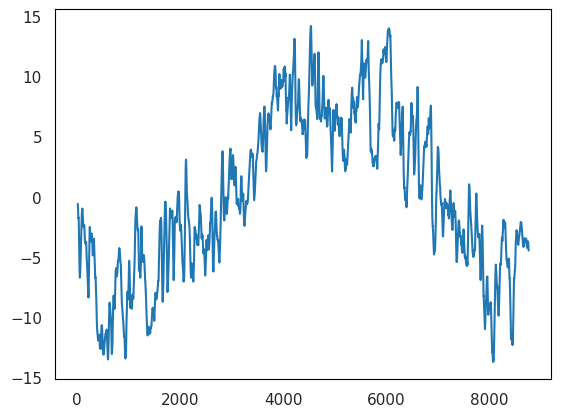

In [16]:
mean_df_temp = df_temp['ta'].rolling(24).mean()
mean_df_temp = mean_df_temp -mean_df_temp.mean()
mean_df_temp.plot()

In [17]:
mean_df_temp_simulated = df_temp_simulated.mean(axis=0).rolling(48).mean()
mean_df_temp_simulated = mean_df_temp_simulated- mean_df_temp_simulated.mean()
mean_df_temp_simulated = mean_df_temp_simulated.iloc[::2]
mean_df_temp_simulated.reset_index(inplace=True, drop=True)

<Axes: >

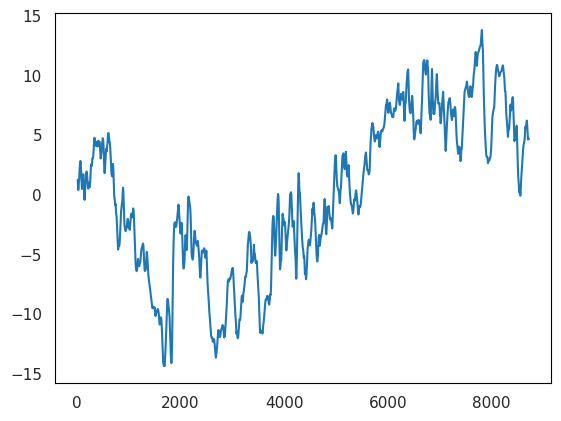

In [18]:
mean_df_temp_simulated.plot()

In [19]:
def roll(series, k):
    # Works for Series or DataFrame
    return series.iloc[np.roll(np.arange(len(series)), k)]

<Axes: >

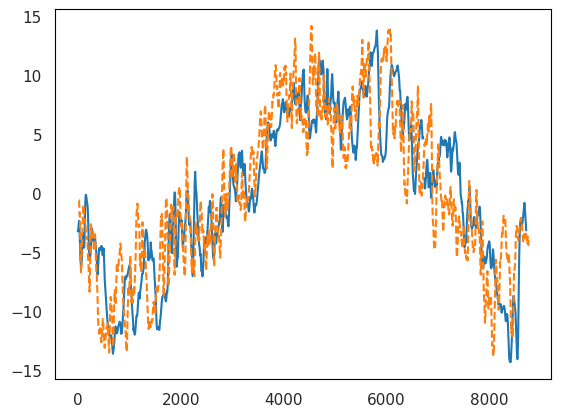

In [20]:
roll(mean_df_temp_simulated, -2000).reset_index(drop=True).plot()
mean_df_temp.plot()

In [21]:
def err_fit(k):
    r = roll(mean_df_temp_simulated, k).reset_index(drop=True)
    return np.mean(np.abs(r - mean_df_temp))

ks = list(range(-2500, -1500))
errs = [err_fit(k) for k in ks]

df_errs = pd.DataFrame({'k': ks, 'err': errs})

<Axes: >

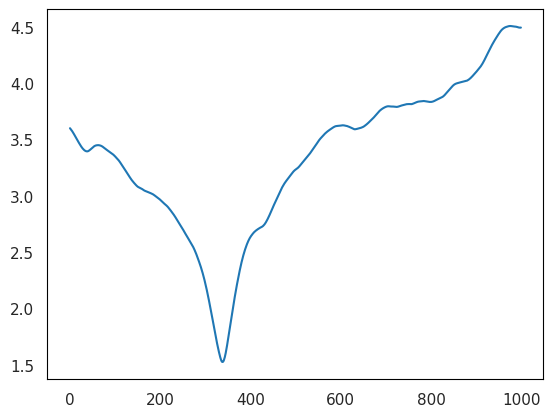

In [22]:
df_errs['err'].plot()

In [23]:
df_errs.idxmin()

k        0
err    338
dtype: int64

In [24]:
df_errs.iloc[338]

k     -2162.000000
err       1.525117
Name: 338, dtype: float64

In [25]:
offset = -2162

<Axes: >

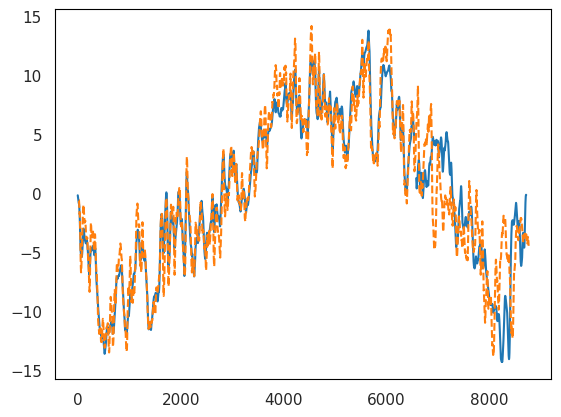

In [26]:
roll(mean_df_temp_simulated, offset).reset_index(drop=True).plot()
mean_df_temp.plot()

In [27]:
df_temp['time'] = pd.to_datetime(df_temp['time'])
df_temp = df_temp.set_index('time')

<Axes: xlabel='time'>

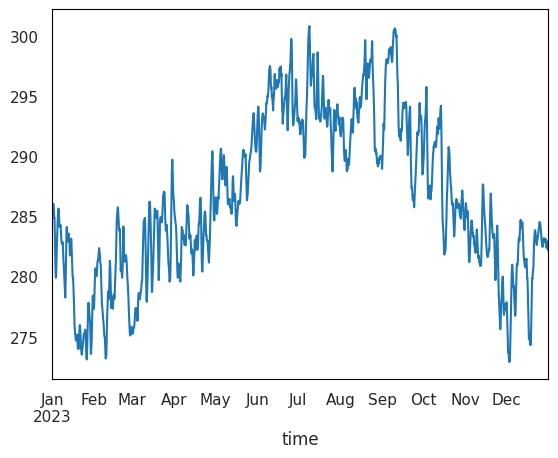

In [28]:
df_temp['ta'].rolling(24).mean().plot()

In [29]:
#demand 2023

In [30]:
df_cons = pd.read_csv(
    path.join(GDC_DATA_PATH, 'real', 'demande_rte_2023.csv')
)
df_cons.head()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J
0,France,Données définitives,2023-01-01,00:00:00,47571.0,46600.0,48000.0
1,France,Données définitives,2023-01-01,00:30:00,46342.0,45500.0,47000.0
2,France,Données définitives,2023-01-01,01:00:00,44790.0,43800.0,45700.0
3,France,Données définitives,2023-01-01,01:30:00,45276.0,44400.0,46200.0
4,France,Données définitives,2023-01-01,02:00:00,45246.0,44300.0,46000.0


<Axes: >

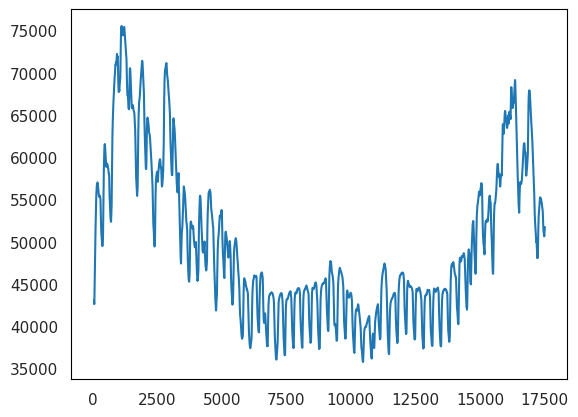

In [31]:
df_cons['Consommation'].rolling(48).mean().plot()

In [32]:
# spot prices 2023
df_prices = pd.read_csv(
    path.join(GDC_DATA_PATH, 'real', 'prices_fr.csv')
)
df_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,France,FRA,2015-01-01 00:00:00,2015-01-01 01:00:00,36.56
1,France,FRA,2015-01-01 01:00:00,2015-01-01 02:00:00,36.56
2,France,FRA,2015-01-01 02:00:00,2015-01-01 03:00:00,36.56
3,France,FRA,2015-01-01 03:00:00,2015-01-01 04:00:00,36.56
4,France,FRA,2015-01-01 04:00:00,2015-01-01 05:00:00,36.56


In [33]:
df_prices['Datetime (UTC)'].iloc[0]

'2015-01-01 00:00:00'

In [34]:
df_prices['date'] = pd.to_datetime(df_prices['Datetime (UTC)'])

In [35]:
df_prices = df_prices.set_index('date')

In [36]:
df_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
date,,,,,
2015-01-01 00:00:00,France,FRA,2015-01-01 00:00:00,2015-01-01 01:00:00,36.56
2015-01-01 01:00:00,France,FRA,2015-01-01 01:00:00,2015-01-01 02:00:00,36.56
2015-01-01 02:00:00,France,FRA,2015-01-01 02:00:00,2015-01-01 03:00:00,36.56
2015-01-01 03:00:00,France,FRA,2015-01-01 03:00:00,2015-01-01 04:00:00,36.56
2015-01-01 04:00:00,France,FRA,2015-01-01 04:00:00,2015-01-01 05:00:00,36.56


In [37]:
df_prices = df_prices.loc['2023']

In [38]:
df_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
date,,,,,
2023-01-01 00:00:00,France,FRA,2023-01-01 00:00:00,2023-01-01 01:00:00,-0.10
2023-01-01 01:00:00,France,FRA,2023-01-01 01:00:00,2023-01-01 02:00:00,-1.33
2023-01-01 02:00:00,France,FRA,2023-01-01 02:00:00,2023-01-01 03:00:00,-4.08
2023-01-01 03:00:00,France,FRA,2023-01-01 03:00:00,2023-01-01 04:00:00,-4.16
2023-01-01 04:00:00,France,FRA,2023-01-01 04:00:00,2023-01-01 05:00:00,-3.58


<Axes: xlabel='date'>

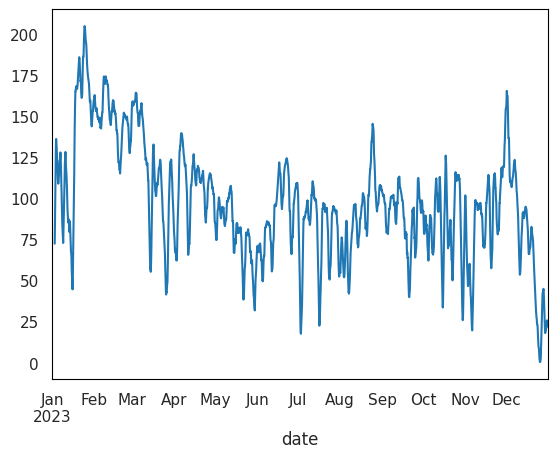

In [39]:
df_prices['Price (EUR/MWhe)'].rolling(48).mean().plot()

<Axes: >

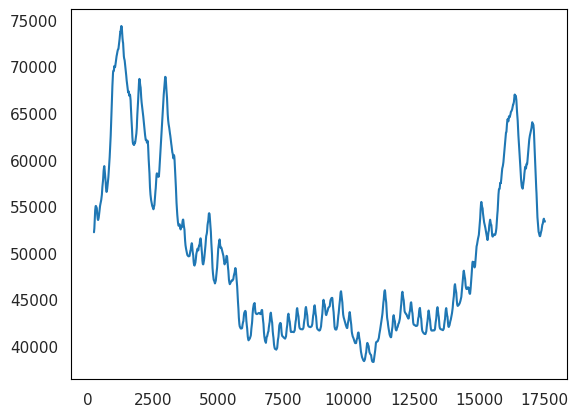

In [40]:
df_cons['Consommation'].rolling(240).mean().plot()

In [41]:
df_cons = pd.read_csv(
    path.join(GDC_DATA_PATH, 'real', 'demande_rte_2023.csv')
)

In [49]:
mean_cons = df_cons['Consommation'].rolling(48).mean()
mean_cons = mean_cons / mean_cons.mean()
mean_cons_simulated = df_load.mean(axis=0).rolling(48).mean()
mean_cons_simulated = mean_cons_simulated / mean_cons_simulated.mean()

<Axes: >

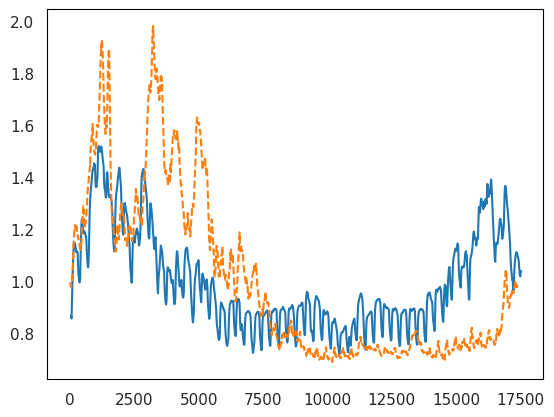

In [53]:
mean_cons.reset_index(drop=True).plot()
roll(mean_cons_simulated, offset).reset_index(drop=True).plot()

In [28]:
df_cons['prediction_error'] = df_cons['Consommation'] - df_cons['Prévision J-1']

In [29]:
df_cons['prediction_update'] = df_cons['Prévision J'] - df_cons['Prévision J-1']

<Axes: >

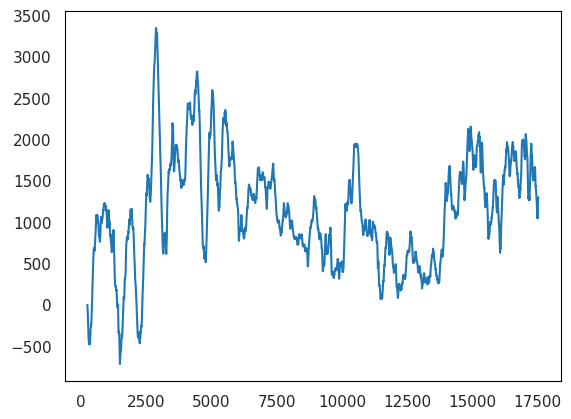

In [33]:
df_cons['prediction_error'].rolling(240).mean().plot()

<Axes: >

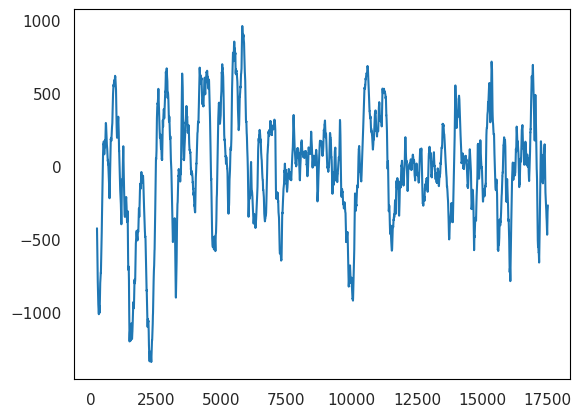

In [34]:
df_cons['prediction_update'].rolling(240).mean().plot()

In [36]:
df_cons.head()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,prediction_error,prediction_update
0,France,Données définitives,2023-01-01,00:00:00,47571.0,46600.0,48000.0,971.0,1400.0
1,France,Données définitives,2023-01-01,00:30:00,46342.0,45500.0,47000.0,842.0,1500.0
2,France,Données définitives,2023-01-01,01:00:00,44790.0,43800.0,45700.0,990.0,1900.0
3,France,Données définitives,2023-01-01,01:30:00,45276.0,44400.0,46200.0,876.0,1800.0
4,France,Données définitives,2023-01-01,02:00:00,45246.0,44300.0,46000.0,946.0,1700.0


In [39]:
df_cons['datetime'] = pd.to_datetime(df_cons['Date'].astype(str) + ' ' + df_cons['Heures'].astype(str))

In [40]:
df_cons = df_cons.set_index('datetime').sort_index()

In [41]:
df_cons

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,prediction_error,prediction_update
datetime,,,,,,,,,
2023-01-01 00:00:00,France,Données définitives,2023-01-01,00:00:00,47571.0,46600.0,48000.0,971.0,1400.0
2023-01-01 00:30:00,France,Données définitives,2023-01-01,00:30:00,46342.0,45500.0,47000.0,842.0,1500.0
2023-01-01 01:00:00,France,Données définitives,2023-01-01,01:00:00,44790.0,43800.0,45700.0,990.0,1900.0
2023-01-01 01:30:00,France,Données définitives,2023-01-01,01:30:00,45276.0,44400.0,46200.0,876.0,1800.0
2023-01-01 02:00:00,France,Données définitives,2023-01-01,02:00:00,45246.0,44300.0,46000.0,946.0,1700.0
...,...,...,...,...,...,...,...,...,...
2023-12-31 21:30:00,France,Données définitives,2023-12-31,21:30:00,53329.0,50100.0,51900.0,3229.0,1800.0
2023-12-31 22:00:00,France,Données définitives,2023-12-31,22:00:00,52719.0,50600.0,52400.0,2119.0,1800.0
2023-12-31 22:30:00,France,Données définitives,2023-12-31,22:30:00,53518.0,51900.0,53700.0,1618.0,1800.0


In [132]:
df_merged = df_cons.join(df_prices, how='inner').join(df_temp, how='inner')
df_merged.head()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,prediction_error,prediction_update,Country,...,snow_height,nebulosity,insolh_duration,glo,pres,pres_sl,station_name,lon,lat,alt
2023-01-01 00:00:00,France,Données définitives,2023-01-01,00:00:00,47571.0,46600.0,48000.0,971.0,1400.0,France,...,0.0,6.0,0.0,0.0,100390.0,101460.0,b'ORLY',2.397,48.717999,86.0
2023-01-01 01:00:00,France,Données définitives,2023-01-01,01:00:00,44790.0,43800.0,45700.0,990.0,1900.0,France,...,0.0,6.0,0.0,0.0,100400.0,101470.0,b'ORLY',2.397,48.717999,86.0
2023-01-01 02:00:00,France,Données définitives,2023-01-01,02:00:00,45246.0,44300.0,46000.0,946.0,1700.0,France,...,0.0,7.0,0.0,0.0,100420.0,101490.0,b'ORLY',2.397,48.717999,86.0
2023-01-01 03:00:00,France,Données définitives,2023-01-01,03:00:00,42919.0,41200.0,43200.0,1719.0,2000.0,France,...,0.0,8.0,0.0,0.0,100490.0,101570.0,b'ORLY',2.397,48.717999,86.0
2023-01-01 04:00:00,France,Données définitives,2023-01-01,04:00:00,39981.0,38300.0,40500.0,1681.0,2200.0,France,...,0.0,7.0,0.0,0.0,100510.0,101590.0,b'ORLY',2.397,48.717999,86.0


In [133]:
df_merged['price'] = df_merged['Price (EUR/MWhe)']

In [134]:
df_merged['conso'] = df_merged['Consommation']

In [135]:
df_merged[['ta', 'conso', 'price']].corr()

,ta,conso,price
ta,1.000000,-0.576830,-0.330088
conso,-0.576830,1.000000,0.489284
price,-0.330088,0.489284,1.000000


In [136]:
model = smf.ols(formula='price ~ conso + ta', data=df_merged).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1404.
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:26:37   Log-Likelihood:                -44660.
No. Observations:                8760   AIC:                         8.933e+04
Df Residuals:                    8757   BIC:                         8.935e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    128.7759     22.133      5.818      0.000      85.391     172.161
conso          0.0020      5e-05     39.348      0.000       0.002       0.002
ta            -0.4528      0.072     -6.300      0.000      -0.594      -0.312
==============================================================================
Omnibus:                      359.241   Durbin-Watson:                   0.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              414.419
Skew:                          -0.486   Prob(JB):                     1.02e-90
Kurtosis:                       3.435   Cond. No.                     2.65e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [137]:
df_merged['conso_prev_hour'] = df_merged['conso'].shift(1)
df_merged['conso_prev_day'] = df_merged['conso'].rolling(24).mean()        # 24 hours ago
df_merged['conso_prev_week']  = df_merged['conso'].rolling(24*7).mean()      # 168 hours ago
df_merged['ta_prev_day'] = df_merged['ta'].rolling(24).mean() 

In [138]:
df_merged = df_merged.dropna(subset=['conso_prev_hour', 'conso_prev_day', 'conso_prev_week', 'ta_prev_day'])
df_merged['ta2'] = np.square(df_merged['ta']-286)


/tmp/ipykernel_1170408/2969108734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['ta2'] = np.square(df_merged['ta']-286)


In [139]:
formula = 'price ~ conso + conso_prev_hour+ conso_prev_day + conso_prev_week + ta + ta2'
model = smf.ols(formula=formula, data=df_merged).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     592.3
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:26:39   Log-Likelihood:                -43491.
No. Observations:                8593   AIC:                         8.700e+04
Df Residuals:                    8586   BIC:                         8.705e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         214.9815     33.820      6.357      0.000     148.686     281.277
conso               0.0030      0.000     15.160      0.000       0.003       0.003
conso_prev_hour    -0.0023      0.000    -11.344      0.000      -0.003      -0.002
conso_prev_day      0.0027      0.000     17.095      0.000       0.002       0.003
conso_prev_week    -0.0017      0.000    -12.932      0.000      -0.002      -0.001
ta                 -0.7289      0.107     -6.821      0.000      -0.938      -0.519
ta2                 0.0920      0.007     12.424      0.000       0.077       0.107
==============================================================================
Omnibus:                      355.812   Durbin-Watson:                   0.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.923
Skew:                          -0.496   Prob(JB):                     4.34e-89
Kurtosis:                       3.389   Cond. No.                     8.29e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [140]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = model.model.exog
vif = pd.Series(
    [variance_inflation_factor(X, i) for i in range(X.shape[1])],
    index=model.model.exog_names)
print(vif)


Intercept          6737.283216
conso                24.819101
conso_prev_hour      25.366366
conso_prev_day       12.654512
conso_prev_week       7.750961
ta                    3.549456
ta2                   1.508567
dtype: float64


In [141]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error


In [148]:
df = df_merged

In [150]:
y = df['price']
X = df[['conso_prev_day', 'ta_prev_day']]

model = SARIMAX(y, exog=X, order=(3,0,0))  # 3 autoregressive lags, no differencing
res = model.fit()
print(res.summary())


y = res.model.endog
y_hat = res.fittedvalues

r2 = r2_score(y, y_hat)
print("Pseudo R²:", r2)

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 8593
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -33580.126
Date:                Fri, 07 Nov 2025   AIC                          67172.251
Time:                        16:28:14   BIC                          67214.604
Sample:                    01-07-2023   HQIC                         67186.696
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
conso_prev_day     0.0023      0.000     16.465      0.000       0.002       0.003
ta_prev_day       -0.0636      0.024     -2.612      0.009      -0.111      -0.016
ar.L1              1.4231      0.007

In [160]:
df = df[['price', 'conso_prev_day', 'ta_prev_day']].dropna().sort_index()


# Combine exogenous regressors
X = df[['conso_prev_day', 'ta_prev_day']]
# Endogenous variable
y = df['price']


model = SARIMAX(y, exog=X, order=(3,0,0))
res = model.fit(disp=False)
print(res.summary())

y_hat = res.fittedvalues
r2 = r2_score(y, y_hat)
rmse = np.sqrt(mean_squared_error(y, y_hat))
print(f"Pseudo R²: {r2:.3f}, RMSE: {rmse:.2f}")

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 8593
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -33580.126
Date:                Fri, 07 Nov 2025   AIC                          67172.251
Time:                        16:40:43   BIC                          67214.604
Sample:                    01-07-2023   HQIC                         67186.696
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
conso_prev_day     0.0023      0.000     16.465      0.000       0.002       0.003
ta_prev_day       -0.0636      0.024     -2.612      0.009      -0.111      -0.016
ar.L1              1.4231      0.007

In [161]:
split_idx = int(len(df) * 0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

In [165]:
model = SARIMAX(y_train, exog=X_train, order=(3,0,0))
res = model.fit(disp=False)
print(res.summary())
y_hat = res.fittedvalues
r2 = r2_score(y_train, y_hat)
rmse = np.sqrt(mean_squared_error(y_train, y_hat))
print(f"Pseudo R²: {r2:.3f}, RMSE: {rmse:.2f}")

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 6874
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -26897.868
Date:                Fri, 07 Nov 2025   AIC                          53807.736
Time:                        16:42:48   BIC                          53848.749
Sample:                    01-07-2023   HQIC                         53821.881
                         - 10-21-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
conso_prev_day     0.0029      0.000     27.404      0.000       0.003       0.003
ta_prev_day       -0.1379      0.018     -7.677      0.000      -0.173      -0.103
ar.L1              1.3902      0.008

In [166]:
model = SARIMAX(y_test, exog=X_test, order=(3,0,0))
res = model.fit(disp=False)
print(res.summary())
y_hat = res.fittedvalues
r2 = r2_score(y_test, y_hat)
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f"Pseudo R²: {r2:.3f}, RMSE: {rmse:.2f}")

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1719
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -6539.234
Date:                Fri, 07 Nov 2025   AIC                          13090.469
Time:                        16:43:21   BIC                          13123.166
Sample:                    10-21-2023   HQIC                         13102.567
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
conso_prev_day     0.0022      0.001      3.719      0.000       0.001       0.003
ta_prev_day       -0.1524      0.112     -1.355      0.175      -0.373       0.068
ar.L1              1.4035      0.018

In [164]:
pred = res.get_forecast(steps=len(y_test), exog=X_test)
y_pred = pred.predicted_mean

# Evaluate
r2_oos = r2_score(y_test, y_pred)
rmse_oos = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Out-of-sample R²: {r2_oos:.3f}, RMSE: {rmse_oos:.2f}")

Out-of-sample R²: -0.789, RMSE: 60.06


<Axes: >

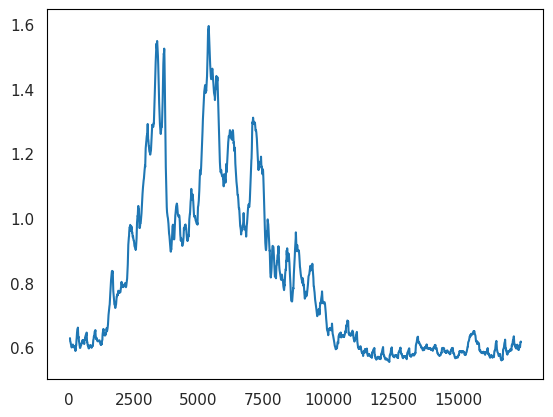

In [80]:
df_load.mean(axis=0).rolling(48).mean().plot()